2025-06-11 10:35:22,446 | INFO    | ==========  STAGE 09: BLENDED R-SCORES ==========
2025-06-11 10:35:22,450 | INFO    | RUN_DIR=C:\Users\Jason Pohl\OneDrive - Bond University\PhD\rff\outputs_rff\event=2008\20250610  SWAN_YEAR=2008  RUN_DATE=20250610
2025-06-11 10:35:22,452 | INFO    | Reading probability matrix → 08_pre2008_AllMetrics_RScores.csv
2025-06-11 10:35:22,634 | INFO    | Rows: 34,862   Metric-prob columns: 10
2025-06-11 10:35:23,977 | INFO    | ✓ blended R-scores written → 09_Blended_RScores.csv



✅ Stage 09 complete – blended file: 09_Blended_RScores.csv


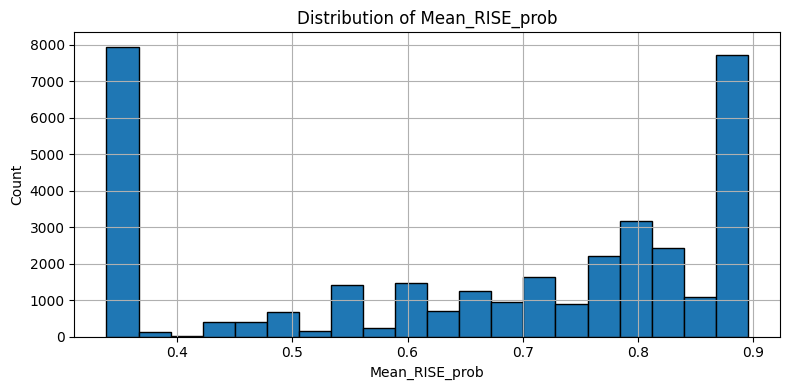

2025-06-11 10:35:24,496 | INFO    | ✅ STAGE 09 finished – artefacts in C:\Users\Jason Pohl\OneDrive - Bond University\PhD\rff\outputs_rff\event=2008\20250610\stage09



Top-10 firms (FY-2007)
Symbol  Mean_RISE_prob
  BD1O        0.895234
   BEN        0.895234
 BENPH        0.895234
 BENPI        0.895234
   BHP        0.895234
   BPT        0.895234
   BSA        0.895234
  BSAO        0.895234
   BUB        0.895234
   CAQ        0.895234

Bottom-10 firms (FY-2007)
Symbol  Mean_RISE_prob
   BP8        0.338857
  BP8O        0.338857
   CLA        0.338857
   BM8        0.378112
 C2FHA        0.378112
   SKS        0.378112
   IVR        0.426163
  IVRO        0.426163
   SBM        0.426163
   SDI        0.426163


In [ ]:
#!/usr/bin/env python
"""
STAGE 09 · Blended R-Score  (speed, depth & combined)
──────────────────────────────────────────────────────
Creates three families of blends:
   • Speed-only      (recovery speed models)
   • Depth-only      (draw-down depth models)
   • RISE / Combined (union of the two — legacy behaviour)

For **each** flavour it writes

    09_Blended_RScores_<Flavour?>_<YEAR>.csv
    09_RScore_Summary_<Flavour?>_<YEAR>.csv
    09_Top10_<Flavour?>_<YEAR>.csv
    09_Bottom10_<Flavour?>_<YEAR>.csv
    09_<Flavour?>_Hist_<YEAR>.png
    09_<Flavour?>_Box_<YEAR>.png
    09_<Flavour?>_Corr_<YEAR>.png
(The empty string flavour “RISE” keeps the original filenames.)
"""
from __future__ import annotations

from pathlib import Path
from typing  import Dict, List
import logging, os, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from scipy.special import logit, expit

from pipeline_utils import load_cfg, resolve_run_dir
warnings.filterwarnings("ignore", category=RuntimeWarning)
plt.rcParams["figure.dpi"] = 110
sns.set_style("whitegrid")

# ══════════════════ 0 · BOOTSTRAP ══════════════════════════════════
CFG: Dict  = load_cfg()
EVENTS     = {str(k): v for k, v in CFG.get("events", {}).items()}

SWAN_YEAR  = str(os.getenv("SWAN_YEAR") or next(iter(EVENTS)))
SWAN_INT   = int(SWAN_YEAR)

RUN_DIR    = resolve_run_dir(swan_year = SWAN_YEAR,
                             run_tag   = os.getenv("RUN_TAG"),
                             must_have = f"stage08/08_pre{SWAN_YEAR}_AllMetrics_RScores.csv")

STAGE_DIR  = RUN_DIR / "stage09"; STAGE_DIR.mkdir(exist_ok=True, parents=True)

logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s | %(levelname)-7s | %(message)s",
                    handlers=[logging.FileHandler(STAGE_DIR/"stage09.log","w","utf-8"),
                              logging.StreamHandler()])
log = logging.getLogger(__name__)
log.info("==========  STAGE 09  –  %s ==========", SWAN_YEAR)

DATE_COL, ID_COL = "ReportDate", "Symbol"
MIN_METRICS      = 6            # rows need ≥ this many metrics to get z-blend

# ══════════════════ 1 · LOAD PROBABILITIES ═════════════════════════
speed_fp = RUN_DIR/"stage08"/f"08_pre{SWAN_YEAR}_AllMetrics_RScores.csv"
depth_fp = RUN_DIR/"stage08"/f"08_pre{SWAN_YEAR}_Depth_AllMetrics_RScores.csv"

df_speed = pd.read_csv(speed_fp)
log.info("Speed   matrix  : %d rows × %d cols", *df_speed.shape)

has_depth = depth_fp.is_file() and depth_fp.stat().st_size
df_depth  = pd.read_csv(depth_fp) if has_depth else pd.DataFrame()
if has_depth:
    log.info("Depth   matrix  : %d rows × %d cols", *df_depth.shape)

df = df_speed.merge(df_depth, on=[ID_COL, DATE_COL], how="outer", suffixes=("",""))

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

def cols_with(prefix:str) -> List[str]:
    return [c for c in df.columns if c.startswith(prefix) and c.endswith(f"_pre{SWAN_YEAR}")]

speed_cols    = cols_with("RScoreProb_")
depth_cols    = cols_with("RScoreDepthProb_")
combined_cols = sorted(set(speed_cols + depth_cols))

# ══════════════════ 2 · BLEND CALCULATOR ══════════════════════════
def add_blend(cols:List[str], label:str):
    """Create z-blend / mean / median for *cols*; append to df in-place."""
    if not cols: return
    z = df[cols].clip(1e-6, 1-1e-6).apply(logit)
    z = (z - z.mean()) / z.std(ddof=0)
    ok = z.count(axis=1) >= MIN_METRICS

    zcol   = f"ZBlend_{label}_prob"
    mean   = f"Mean_{label}_prob"
    median = f"Median_{label}_prob"

    df[zcol]   = expit(z.mean(axis=1, skipna=True))
    df.loc[~ok, zcol] = np.nan
    df[mean]   = df[cols].mean(axis=1, skipna=True)
    df[median] = df[cols].median(axis=1, skipna=True)

add_blend(speed_cols,   "Speed")
add_blend(depth_cols,   "Depth")
add_blend(combined_cols,"RISE")          # legacy / combined

# deciles on combined mean for continuity
q10, q90 = df["Mean_RISE_prob"].quantile([.10,.90])
df["TopDecile"]    = (df["Mean_RISE_prob"] >= q90).astype("int8")
df["BottomDecile"] = (df["Mean_RISE_prob"] <= q10).astype("int8")

# ══════════════════ 3 · SAVE BLENDED MATRICES ═════════════════════
def save_matrix(cols:List[str], flavour:str):
    if not cols: return
    out_name = ("09_Blended_RScores_" +
                ("" if flavour=="RISE" else f"{flavour}_") +
                f"{SWAN_YEAR}.csv")
    df[[ID_COL, DATE_COL]+cols].to_csv(STAGE_DIR/out_name, index=False)

save_matrix(speed_cols,   "Speed")
save_matrix(depth_cols,   "Depth")
save_matrix(combined_cols,"RISE")          # legacy filename

# ══════════════════ 4 · DIAGNOSTICS BY FLAVOUR ════════════════════
def do_diagnostics(pref:str, base_cols:List[str]):
    if not base_cols: return
    tag = "" if pref=="RISE" else f"{pref}_"

    # summary stats --------------------------------------------------
    df[[f"ZBlend_{pref}_prob",
        f"Mean_{pref}_prob",
        f"Median_{pref}_prob"]].describe(percentiles=[.1,.25,.5,.75,.9]).T.round(4)\
       .to_csv(STAGE_DIR/f"09_RScore_Summary_{tag}{SWAN_YEAR}.csv")

    # top / bottom ---------------------------------------------------
    snap = df[df[DATE_COL].dt.year == SWAN_INT-1]
    if not snap.empty:
        snap.nlargest(10, f"Mean_{pref}_prob")[[ID_COL,f"Mean_{pref}_prob"]]\
            .to_csv(STAGE_DIR/f"09_Top10_{tag}{SWAN_YEAR}.csv", index=False)
        snap.nsmallest(10, f"Mean_{pref}_prob")[[ID_COL,f"Mean_{pref}_prob"]]\
            .to_csv(STAGE_DIR/f"09_Bottom10_{tag}{SWAN_YEAR}.csv", index=False)

    # histogram ------------------------------------------------------
    plt.figure(figsize=(8,4))
    df[f"Mean_{pref}_prob"].dropna().hist(bins=20, edgecolor="k")
    plt.title(f"Distribution of Mean_{pref}_prob")
    plt.tight_layout()
    plt.savefig(STAGE_DIR/f"09_{tag}Hist_{SWAN_YEAR}.png", dpi=110)
    plt.close()

    # box-plot -------------------------------------------------------
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df[[f"ZBlend_{pref}_prob",
                         f"Mean_{pref}_prob",
                         f"Median_{pref}_prob"]], orient="h")
    plt.title(f"{pref} blend distributions")
    plt.tight_layout()
    plt.savefig(STAGE_DIR/f"09_{tag}Box_{SWAN_YEAR}.png", dpi=110)
    plt.close()

    # correlation heat-map ------------------------------------------
    corr = df[[f"ZBlend_{pref}_prob",
               f"Mean_{pref}_prob",
               f"Median_{pref}_prob"]].corr()
    plt.figure(figsize=(3.4,3))
    sns.heatmap(corr, annot=True, vmin=0, vmax=1, cmap="viridis", fmt=".2f")
    plt.title(f"{pref} blend correlation")
    plt.tight_layout()
    plt.savefig(STAGE_DIR/f"09_{tag}Corr_{SWAN_YEAR}.png", dpi=110)
    plt.close()

do_diagnostics("Speed", speed_cols)
do_diagnostics("Depth", depth_cols)
do_diagnostics("RISE",  combined_cols)     # legacy combined

log.info("🎉  Stage 09 complete – artefacts in %s", STAGE_DIR)
print(f"\n✅ Stage 09 complete – outputs saved to {STAGE_DIR}\n")

